In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
#needed for Jupyter Notebook, if want plots to show inline
%matplotlib inline 
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

In [2]:
import glob
import re
plt.style.available
plt.style.use('seaborn-colorblind')

In [3]:
from collections import Counter
from datetime import datetime, timedelta

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score

In [4]:
%whos

Variable                 Type        Data/Info
----------------------------------------------
Counter                  type        <class 'collections.Counter'>
GridSearchCV             ABCMeta     <class 'sklearn.model_sel<...>on._search.GridSearchCV'>
LogisticRegression       type        <class 'sklearn.linear_mo<...>stic.LogisticRegression'>
MinMaxScaler             type        <class 'sklearn.preprocessing.data.MinMaxScaler'>
RandomForestClassifier   ABCMeta     <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
StandardScaler           type        <class 'sklearn.preproces<...>ing.data.StandardScaler'>
datetime                 type        <class 'datetime.datetime'>
glob                     module      <module 'glob' from '/hom<...>3/lib/python3.6/glob.py'>
np                       module      <module 'numpy' from '/ho<...>kages/numpy/__init__.py'>
pd                       module      <module 'pandas' from '/h<...>ages/pandas/__init__.py'>
pdist                    function   

In [5]:
pd.__version__

'0.23.0'

## Loading data

In [6]:
def read2000sMatches(dirname):
    allFiles = glob.glob(dirname + "/atp_matches_2" + "*.csv")
    matches = pd.DataFrame()
    list_ = list()
    for filen in allFiles:
        df = pd.read_csv(filen,
                         index_col=None,
                         header=0,
                         parse_dates=[0])
                         #date_parser=lambda t:parse(t))
        list_.append(df)
    matches = pd.concat(list_)
    return matches

def read1900sMatches(dirname):
    allFiles = glob.glob(dirname + "/atp_matches_1" + "*.csv")
    matches = pd.DataFrame()
    list_ = list()
    for filen in allFiles:
        df = pd.read_csv(filen,
                         index_col=None,
                         header=0,
                         parse_dates=[0])
                         #date_parser=lambda t:parse(t))
        list_.append(df)
    matches = pd.concat(list_)
    return matches

In [7]:
matches2000s=read2000sMatches('tennis/')
matches1900s=read1900sMatches('tennis/')
matches_SackmannAll = pd.concat([matches1900s,matches2000s])
matches_SackmannAll.shape # (167879, 49)

(167879, 49)

## Take only data with detailed stats

In [8]:
df_stats = matches_SackmannAll[~pd.isnull(matches_SackmannAll['w_ace'])]
#still has many columns that are mising data
# df_stats.info()

In [9]:
df_win = df_stats[['tourney_id', 'match_num','tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date',  'score', 'best_of',
       'round', 'minutes','winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'winner_rank', 'winner_rank_points','w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms',
       'w_bpSaved', 'w_bpFaced']]
df_loss = df_stats[['tourney_id','match_num','tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date',  'score', 'best_of',
       'round', 'minutes','loser_id', 'loser_seed',
       'loser_entry', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc',
       'loser_age', 'loser_rank', 'loser_rank_points','l_ace', 'l_df',
       'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved',
       'l_bpFaced']]

### Make 'win' and 'loss' columns compatible

#### Situation by poor concatenation (appending to the right NOT below), without changing column names

In [10]:
df_win_loss = pd.concat([df_win,df_loss],axis=1)
# each row has basic info repeated
# each row has two 'target'

#### Making compatible

In [11]:
df_win.columns = [s.replace("winner_", "") for s in df_win.columns]
df_win.columns = [s.replace("w_", "") for s in df_win.columns]
df_loss.columns = [s.replace("loser_", "") for s in df_win.columns]
df_loss.columns = [s.replace("l_", "") for s in df_win.columns]

df_win['target']=1
df_loss['target']=0


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [12]:
df_win_loss = pd.concat([df_win,df_loss])


In [13]:
%whos

Variable                 Type         Data/Info
-----------------------------------------------
Counter                  type         <class 'collections.Counter'>
GridSearchCV             ABCMeta      <class 'sklearn.model_sel<...>on._search.GridSearchCV'>
LogisticRegression       type         <class 'sklearn.linear_mo<...>stic.LogisticRegression'>
MinMaxScaler             type         <class 'sklearn.preprocessing.data.MinMaxScaler'>
RandomForestClassifier   ABCMeta      <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
StandardScaler           type         <class 'sklearn.preproces<...>ing.data.StandardScaler'>
datetime                 type         <class 'datetime.datetime'>
df_loss                  DataFrame         tourney_id  match_nu<...>[81281 rows x 31 columns]
df_stats                 DataFrame         tourney_id  tourney_<...>[81281 rows x 49 columns]
df_win                   DataFrame         tourney_id  match_nu<...>[81281 rows x 31 columns]
df_win_loss             

In [14]:
del(matches1900s,matches2000s)

In [ ]:
del(df_win,df_loss)

In [72]:
df_stats['tourney_level'].unique()

array(['A', 'M', 'G', 'F', 'D', 'C'], dtype=object)

In [75]:
df_stats[df_stats['tourney_level']=='F'].head(100)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
3487,1992-605,Tour Finals,Carpet,8,F,19921116,1,101964,NaN,NaN,Goran Ivanisevic,L,193.0,CRO,21.177276,4.0,2564.0,102021,NaN,NaN,Michael Chang,R,175.0,USA,20.733744,5.0,2277.0,7-6(4) 6-2,3,RR,99.0,14.0,4.0,86.0,52.0,47.0,16.0,10.0,1.0,1.0,8.0,4.0,83.0,42.0,33.0,20.0,10.0,5.0,7.0
3488,1992-605,Tour Finals,Carpet,8,F,19921116,2,101964,NaN,NaN,Goran Ivanisevic,L,193.0,CRO,21.177276,4.0,2564.0,101793,NaN,NaN,Jim Courier,R,185.0,USA,22.250513,1.0,3379.0,6-3 6-3,3,RR,75.0,6.0,3.0,58.0,31.0,29.0,14.0,9.0,3.0,3.0,4.0,1.0,57.0,38.0,29.0,7.0,9.0,1.0,4.0
3489,1992-605,Tour Finals,Carpet,8,F,19921116,3,101964,NaN,NaN,Goran Ivanisevic,L,193.0,CRO,21.177276,4.0,2564.0,101990,NaN,NaN,Richard Krajicek,R,196.0,NED,20.947296,10.0,1795.0,6-4 6-3,3,RR,74.0,5.0,2.0,60.0,34.0,31.0,15.0,10.0,0.0,0.0,5.0,1.0,77.0,43.0,30.0,16.0,9.0,4.0,6.0
3490,1992-605,Tour Finals,Carpet,8,F,19921116,4,101414,NaN,NaN,Boris Becker,R,190.0,GER,24.985626,7.0,2129.0,101964,NaN,NaN,Goran Ivanisevic,L,193.0,CRO,21.177276,4.0,2564.0,4-6 6-4 7-6(7),3,SF,142.0,16.0,3.0,114.0,77.0,67.0,20.0,16.0,2.0,3.0,23.0,6.0,130.0,83.0,70.0,25.0,16.0,1.0,2.0
3491,1992-605,Tour Finals,Carpet,8,F,19921116,5,101990,NaN,NaN,Richard Krajicek,R,196.0,NED,20.947296,10.0,1795.0,102021,NaN,NaN,Michael Chang,R,175.0,USA,20.733744,5.0,2277.0,2-6 6-3 7-6(4),3,RR,143.0,7.0,3.0,106.0,69.0,52.0,19.0,15.0,3.0,6.0,3.0,3.0,88.0,56.0,41.0,19.0,14.0,0.0,2.0
3492,1992-605,Tour Finals,Carpet,8,F,19921116,6,101793,NaN,NaN,Jim Courier,R,185.0,USA,22.250513,1.0,3379.0,102021,NaN,NaN,Michael Chang,R,175.0,USA,20.733744,5.0,2277.0,7-5 6-2,3,RR,119.0,10.0,1.0,94.0,72.0,54.0,11.0,10.0,10.0,10.0,6.0,3.0,82.0,48.0,36.0,12.0,10.0,4.0,7.0
3493,1992-605,Tour Finals,Carpet,8,F,19921116,7,101948,NaN,NaN,Pete Sampras,R,185.0,USA,21.264887,3.0,2937.0,101414,NaN,NaN,Boris Becker,R,190.0,GER,24.985626,7.0,2129.0,7-6(5) 7-6(3),3,RR,107.0,13.0,1.0,84.0,54.0,49.0,23.0,12.0,1.0,1.0,12.0,6.0,93.0,51.0,48.0,20.0,12.0,1.0,1.0
3494,1992-605,Tour Finals,Carpet,8,F,19921116,8,101414,NaN,NaN,Boris Becker,R,190.0,GER,24.985626,7.0,2129.0,101434,NaN,NaN,Petr Korda,L,190.0,CZE,24.815880,6.0,2174.0,6-4 6-2,3,RR,92.0,11.0,5.0,71.0,36.0,29.0,17.0,9.0,5.0,5.0,1.0,2.0,56.0,29.0,19.0,14.0,9.0,6.0,9.0
3495,1992-605,Tour Finals,Carpet,8,F,19921116,9,101414,NaN,NaN,Boris Becker,R,190.0,GER,24.985626,7.0,2129.0,101222,NaN,NaN,Stefan Edberg,R,188.0,SWE,26.825462,2.0,3236.0,6-4 6-0,3,RR,69.0,10.0,0.0,55.0,38.0,32.0,12.0,8.0,0.0,0.0,1.0,4.0,52.0,28.0,17.0,8.0,8.0,4.0,8.0
3496,1992-605,Tour Finals,Carpet,8,F,19921116,10,101414,NaN,NaN,Boris Becker,R,190.0,GER,24.985626,7.0,2129.0,101793,NaN,NaN,Jim Courier,R,185.0,USA,22.250513,1.0,3379.0,6-4 6-3 7-5,5,F,148.0,14.0,6.0,117.0,67.0,55.0,24.0,15.0,3.0,4.0,9.0,5.0,108.0,65.0,45.0,22.0,16.0,8.0,13.0


#### Fill missing values

In [16]:
## fill method of entry for most players with 'standard'; mostly missing values
df_win_loss['entry'] = df_win_loss['entry'].fillna('standard')

## better way might be max(33,rank) ## 33 is the minumum non-seeded value
##high positive value because negative associates with better rank
df_win_loss['seed'] = df_win_loss['seed'].fillna(9999)
df_win_loss['seed'] = df_win_loss['seed'].astype(int)

#rank, and rank_points have ~4000 missign out of 162000
df_win_loss[['rank','rank_points']] = df_win_loss.groupby('name')[['rank','rank_points']]\
                                        .transform(lambda x: x.fillna(x.mean()))
#rank, and rank_points have some more missing values: set to maximum ranking and minimum rank points
df_win_loss['rank'] = df_win_loss['rank']\
                                        .transform(lambda x: x.fillna(x.max()))
df_win_loss['rank_points'] = df_win_loss['rank_points']\
                                        .transform(lambda x: x.fillna(x.min()))


#### more filling of missing values

In [17]:
### for this 1st epicycle: don't want score,2 scores missing,, , 

In [18]:
## set 'hand' to U ('unknown') ~35 missing 'hand'
df_win_loss['hand'] = df_win_loss['hand'].fillna('U')

In [19]:
df_win_loss['hand'].value_counts() #R    138155 L     23661 U       746

R    138155
L     23661
U       746
Name: hand, dtype: int64

In [20]:
# set missing height, age  to average for all people ~7000 missing heights, ~100 missing age
df_win_loss[['age','ht']] = df_win_loss[['age','ht']]\
                                        .transform(lambda x: x.fillna(x.mean()))

In [21]:
## set missing minutes to average age of all ~5000 missing minutes
df_win_loss['minutes'] = df_win_loss['minutes']\
                                        .transform(lambda x: x.fillna(x.mean()))

In [22]:
(df_win_loss['age']).value_counts() #87 (most) occurrences of 23.7919
len(df_win_loss.loc[pd.isnull(df_win_loss['age']),'age']) # 0 good
(df_win_loss['ht']).value_counts() #25899 (most) occurrences of 185 (cm)
len(df_win_loss.loc[pd.isnull(df_win_loss['ht']),'ht']) # 0 good

0

## Dummying categorical variables

In [23]:
df_win_loss = pd.concat([df_win_loss,\
                         pd.get_dummies(df_win_loss['surface'])],axis=1)

* Hard      80028 
* Clay      54282 
* Grass     16366 
* Carpet    11736 
* None        150 

Name: surface, dtype: int64

In [24]:
df_win_loss.drop('surface', axis=1,inplace=True)     

In [25]:
df_win_loss = pd.concat([df_win_loss,\
                         pd.get_dummies(df_win_loss['hand'])],axis=1)

In [26]:
df_win_loss.drop('hand', axis=1,inplace=True)

In [27]:
df_win_loss = pd.concat([df_win_loss,\
                         pd.get_dummies(df_win_loss['tourney_level'])],axis=1)

In [28]:
df_win_loss.drop('tourney_level', axis=1,inplace=True)

In [29]:
df_win_loss.columns

Index(['tourney_id', 'match_num', 'tourney_name', 'drasize', 'tourney_date',
       'score', 'best_of', 'round', 'minutes', 'id', 'seed', 'entry', 'name',
       'ht', 'ioc', 'age', 'rank', 'rank_points', 'ace', 'df', 'svpt', '1stIn',
       '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced', 'target', 'Carpet',
       'Clay', 'Grass', 'Hard', 'None', 'L', 'R', 'U', 'A', 'C', 'D', 'F', 'G',
       'M'],
      dtype='object')

In [30]:
#Other than score all values are filled, at 162562
#df_win_loss.info()

In [31]:
df_pred_cols=df_win_loss[[ 
        'minutes', 
       'ht', 'age', 'rank_points', 'ace', 'df',
       'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced',
       'Carpet', 'Clay', 'Grass', 'Hard', 'None', 'L', 'R', 'U', 'A',
       'C', 'D', 'F', 'G', 'M']]

## Selecting the time subset of data

### Exploration

In [32]:
df_win_loss.columns


Index(['tourney_id', 'match_num', 'tourney_name', 'drasize', 'tourney_date',
       'score', 'best_of', 'round', 'minutes', 'id', 'seed', 'entry', 'name',
       'ht', 'ioc', 'age', 'rank', 'rank_points', 'ace', 'df', 'svpt', '1stIn',
       '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced', 'target', 'Carpet',
       'Clay', 'Grass', 'Hard', 'None', 'L', 'R', 'U', 'A', 'C', 'D', 'F', 'G',
       'M'],
      dtype='object')

In [33]:
tourney_date=df_win_loss['tourney_date'].values
type(np.max(tourney_date)) #20180521, np.int64
np.min(tourney_date) #19901231

19901231

In [34]:
# shows that data not easily converted to date
len(pd.to_datetime(df_win_loss['tourney_date']).unique()) #1078

1078

### Conversion of 'tourney_date' to datetime variable

In [35]:
## this conversion works, have to reassign becuase operation is not inplace
df_win_loss['tourney_date']= pd.to_datetime(df_win_loss['tourney_date'].apply(str))
type(df_win_loss['tourney_date']) #seriers, post-pend '.values':np.ndarray of datetimes
df_win_loss['tourney_date'].apply(lambda x: x.year).unique()
# 1992, 1991, 1993, 1996, 1999, 1994, 1995, 1997, 1998, 1990, 2004,
#        2008, 2007, 2015, 2012, 2003, 2002, 2000, 2001, 2013, 2009, 2017,
#        2014, 2010, 2006, 2005, 2011, 2016, 2018

# df_win_loss.groupby(df_win_loss['tourney_date'].apply(lambda x: x.year))['tourney_date']

array([1992, 1991, 1993, 1996, 1999, 1994, 1995, 1997, 1998, 1990, 2004,
       2008, 2007, 2015, 2012, 2003, 2002, 2000, 2001, 2013, 2009, 2017,
       2014, 2010, 2006, 2005, 2011, 2016, 2018])

In [36]:
df_win_loss.index = df_win_loss['tourney_date']
df_win_loss.set_index(np.arange(1,len(df_win_loss)+1),inplace=True)

In [37]:
# datetime.now() #5 hours ahead of Central Standard

In [38]:
one_year = timedelta(days=365)
# print(s[date_index - one_day]

### Get a duration of a year and limit dataframe to year before stipulated date

In [39]:
date = pd.datetime(2010,11,23)
one_year=timedelta(days=370) 
df_one_year = df_win_loss[(df_win_loss.tourney_date<date) & (df_win_loss.tourney_date> date-one_year)]
df_one_year.shape #5432,42; 'days=500', shape is 7544,42

(5462, 42)

In [40]:
# Checking which years the data of resultant dataframe is from
df_one_year['tourney_date'].apply(lambda x: x.year).unique()

array([2009, 2010])

### Conclsion: get a one-year basis dataframe 

## Get player data for the last  year

#### One method, Masking: Checking Roger Federer

In [41]:
#Works but gives same value, replated for all columsn of data frame
df_win_loss[df_win_loss['name']=='Roger Federer'].count()
#Works and give a single value as I want
df_win_loss.loc[df_win_loss['name']=='Roger Federer', 'name'].count() #1339
#Seems there are other Roger's, checked a few lines down:
df_win_loss.loc[df_win_loss['name'].str.contains('Roger'), 'name'].count() #1652
#But only one Federer, number matches that of 'Roger Federer':
df_win_loss.loc[df_win_loss['name'].str.contains('Federer'), 'name'].count() #1339
#Gets expect result of 313 Roger's not named Federer (1652-1339)
df_win_loss.loc[(df_win_loss['name'].str.contains('Roger'))&(df_win_loss['name']!='Roger Federer'), 'name'].count() 

313

In [42]:
# Who are those non-Roger Federer people
#df_win_loss.loc[(df_win_loss['name'].str.contains('Roger'))&(df_win_loss['name']!='Roger Federer'), 'name'].tail(100)

#### Check that player corresponds to unique ID 'id'

In [43]:
df_win_loss.loc[df_win_loss['name']=='Roger Federer', 'id'].unique()  #just one id, good, 103819

array([103819])

#### Other method, Grouping: Checking Novak and Nadal

In [44]:
player1='Rafael Nadal'
player2='Novak Djokovic'
df_one_year.groupby('name').get_group(player1) 
df_one_year.groupby('name').get_group(player2)

,tourney_id,match_num,tourney_name,drasize,tourney_date,score,best_of,round,minutes,id,seed,entry,name,ht,ioc,age,rank,rank_points,ace,df,svpt,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,target,Carpet,Clay,Grass,Hard,None,L,R,U,A,C,D,F,G,M
54535,2009-605,13,Tour Finals,8,2009-11-22,3-6 6-4 7-5,3,RR,167.0,104925,9999,standard,Novak Djokovic,188.0,SRB,22.507871,3.0,7910.0,2.0,4.0,100.0,63.0,42.0,20.0,16.0,5.0,8.0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0
54536,2009-605,14,Tour Finals,8,2009-11-22,7-6(5) 6-3,3,RR,118.0,104925,9999,standard,Novak Djokovic,188.0,SRB,22.507871,3.0,7910.0,2.0,3.0,73.0,37.0,29.0,19.0,11.0,4.0,6.0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0
60092,2010-5053,13,Belgrade,28,2010-05-03,6-4 6-4,3,R16,91.0,104925,1,standard,Novak Djokovic,188.0,SRB,22.948665,2.0,6970.0,0.0,4.0,63.0,38.0,21.0,12.0,10.0,2.0,6.0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0
60150,2010-540,17,Wimbledon,128,2010-06-21,4-6 6-2 3-6 6-4 6-2,5,R128,231.0,104925,3,standard,Novak Djokovic,188.0,SRB,23.082820,3.0,6545.0,17.0,12.0,137.0,79.0,54.0,29.0,23.0,10.0,17.0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0
60206,2010-540,73,Wimbledon,128,2010-06-21,7-6(5) 6-1 6-4,5,R64,117.0,104925,3,standard,Novak Djokovic,188.0,SRB,23.082820,3.0,6545.0,9.0,1.0,89.0,58.0,47.0,21.0,15.0,1.0,1.0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0
60233,2010-540,101,Wimbledon,128,2010-06-21,6-1 6-4 6-4,5,R32,101.0,104925,3,standard,Novak Djokovic,188.0,SRB,23.082820,3.0,6545.0,11.0,5.0,75.0,50.0,41.0,16.0,14.0,0.0,0.0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0
60247,2010-540,115,Wimbledon,128,2010-06-21,7-5 6-4 3-6 6-4,5,R16,174.0,104925,3,standard,Novak Djokovic,188.0,SRB,23.082820,3.0,6545.0,9.0,9.0,124.0,75.0,57.0,26.0,21.0,6.0,9.0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0
60254,2010-540,122,Wimbledon,128,2010-06-21,6-3 6-2 6-2,5,QF,111.0,104925,3,standard,Novak Djokovic,188.0,SRB,23.082820,3.0,6545.0,4.0,3.0,65.0,41.0,35.0,18.0,13.0,0.0,0.0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0
60504,2010-560,48,US Open,128,2010-08-30,6-3 3-6 2-6 7-5 6-3,5,R128,220.0,104925,3,standard,Novak Djokovic,188.0,SRB,23.274470,3.0,6665.0,3.0,4.0,161.0,105.0,70.0,28.0,24.0,9.0,14.0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0
60544,2010-560,88,US Open,128,2010-08-30,7-5 6-3 7-6(6),5,R64,143.0,104925,3,standard,Novak Djokovic,188.0,SRB,23.274470,3.0,6665.0,4.0,8.0,101.0,70.0,53.0,19.0,17.0,4.0,5.0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0


## Iterating through groups to aggregate variables (abandoned)

## Some model, any model

In [45]:
df_win_loss.head()

,tourney_id,match_num,tourney_name,drasize,tourney_date,score,best_of,round,minutes,id,seed,entry,name,ht,ioc,age,rank,rank_points,ace,df,svpt,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,target,Carpet,Clay,Grass,Hard,None,L,R,U,A,C,D,F,G,M
1,1992-237,1,Guaruja,32,1992-10-26,6-4 6-4,3,R32,97.0,101063,1,standard,Jordi Arrese,175.0,ESP,28.158795,29.0,946.0,4.0,0.0,67.0,44.0,30.0,11.0,10.0,5.0,7.0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0
2,1992-237,2,Guaruja,32,1992-10-26,6-2 6-4,3,R32,65.0,100652,9999,WC,Cassio Motta,180.0,BRA,32.676249,201.0,171.0,7.0,4.0,52.0,35.0,29.0,9.0,9.0,1.0,1.0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0
3,1992-237,3,Guaruja,32,1992-10-26,6-1 6-4,3,R32,82.0,101594,9999,Q,Carsten Arriens,193.0,GER,23.542779,210.0,160.0,4.0,0.0,58.0,39.0,32.0,10.0,9.0,3.0,3.0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0
4,1992-237,4,Guaruja,32,1992-10-26,7-6(4) 6-1,3,R32,95.0,101761,7,standard,Jaime Oncins,196.0,BRA,22.362765,52.0,650.0,5.0,7.0,73.0,44.0,35.0,11.0,10.0,3.0,5.0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0
5,1992-237,5,Guaruja,32,1992-10-26,6-3 3-6 6-4,3,R32,123.0,101174,9999,WC,Fernando Roese,190.0,BRA,27.173169,187.0,185.0,4.0,4.0,79.0,47.0,33.0,11.0,14.0,4.0,10.0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0


In [46]:
## Concern: if I average based on a player, will there be a possibility that nulls are returned?
## Thought: Should alleviaete concern if only top ~100 people are included (maybe 128 is more 'tennis')

# How many people of rank 100 were there, 263 different people..
len(df_win_loss.loc[df_win_loss['rank']==100,'name'].unique())
# How many people of rank 100 were there, 263 different people..
len(df_win_loss.loc[df_win_loss['rank']==100,'name'].unique())

##Nut-cracking: just go with it

263

#### Some model, any model: do training for 2 years and test for one year 
Choose 2008-2011 (2008 for calcs for 2009,2009-2010 for train,2011 for test)

### Preliminaries established from previous work:

In [47]:
type(df_win_loss.tourney_date.values)

numpy.ndarray

In [48]:
df_wl_2008_11 = df_win_loss[(df_win_loss.tourney_date.apply(lambda x:x.year)<2012) \
                            & (df_win_loss.tourney_date.apply(lambda x:x.year)>2007)]
#Below show that this gives what wanted (array([2008, 2009, 2010, 2011]))
# df_win_loss.loc[(df_win_loss.tourney_date.apply(lambda x:x.year)<2012) \
#                 & (df_win_loss.tourney_date.apply(lambda x:x.year)>2007),'tourney_date'].apply(lambda x: x.year).unique()

### Some model, any model: what needed to generate training data

In [49]:
# 'tourney_date' included compared to previous, for purpose of stat aggregation
df_wl_2008_11_for_pred = df_wl_2008_11[['name','tourney_date','minutes', 
       'ht', 'age', 'rank_points', 'ace', 'df',
       'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced',
       'Carpet', 'Clay', 'Grass', 'Hard', 'None', 'L', 'R', 'U', 'A',
       'C', 'D', 'F', 'G', 'M','target']]

#### Getting a limited dataset to test code:

In [50]:
## what player is good for this 
df_wl_2008_11_for_pred.groupby('name').filter(lambda x: len(x) > 20)['name'].value_counts()
## getting David Ferrer data (281 rows)
df_test = df_wl_2008_11_for_pred[df_wl_2008_11_for_pred['name']=='David Ferrer']
df_test.shape

(281, 30)

#### What I am trying to do:
1. start with 2008 to 2011 data
2. make a new dataframe that calculates stats of **each match** of year 2009 and 2010
based on **all matches by that player** in prevous year
3. restrict new dataframe: remove 'tourney_date' and 'name'
4. train model on this generated data 
5. make a new dataframe that calculates stats of **each match** of year 2011 
based on **all matches by that player** in prevous year 
6. using trained model, predict the outcome

In [51]:
whos

Variable                 Type         Data/Info
-----------------------------------------------
Counter                  type         <class 'collections.Counter'>
GridSearchCV             ABCMeta      <class 'sklearn.model_sel<...>on._search.GridSearchCV'>
LogisticRegression       type         <class 'sklearn.linear_mo<...>stic.LogisticRegression'>
MinMaxScaler             type         <class 'sklearn.preprocessing.data.MinMaxScaler'>
RandomForestClassifier   ABCMeta      <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
StandardScaler           type         <class 'sklearn.preproces<...>ing.data.StandardScaler'>
date                     datetime     2010-11-23 00:00:00
datetime                 type         <class 'datetime.datetime'>
df_one_year              DataFrame           tourney_id  match_<...>n[5462 rows x 42 columns]
df_pred_cols             DataFrame          minutes     ht     <...>162562 rows x 27 columns]
df_stats                 DataFrame         tourney_id  tourn

In [52]:
# for use after running next cell to repeat running it...remove cacheing
# del(idx,gen_row,df_preds_2009_11,one_row)


In [53]:
df_test.columns.drop(['tourney_date','name'])

Index(['minutes', 'ht', 'age', 'rank_points', 'ace', 'df', 'svpt', '1stIn',
       '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced', 'Carpet', 'Clay',
       'Grass', 'Hard', 'None', 'L', 'R', 'U', 'A', 'C', 'D', 'F', 'G', 'M',
       'target'],
      dtype='object')

#### Trying rolling windows in pandas:


In [54]:
#Sorting the dataframe on time as prestep:

df_win_loss.columns
# Index(['tourney_id', 'match_num', 'tourney_name', 'drasize', 'tourney_date',
#        'score', 'best_of', 'round', 'minutes', 'id', 'seed', 'entry', 'name',
#        'ht', 'ioc', 'age', 'rank', 'rank_points', 'ace', 'df', 'svpt', '1stIn',
#        '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced', 'target', 'Carpet',
#        'Clay', 'Grass', 'Hard', 'None', 'L', 'R', 'U', 'A', 'C', 'D', 'F', 'G',
#        'M'],
#       dtype='object')

# check datetime column is indeed datatime
#df_win_loss.tourney_date.apply(lambda date: date.year) #returns years

df_wl_sort = df_win_loss.sort_values(['tourney_date','match_num'],ascending=[1,1],axis=0)

df_wl_sort_colSlct = df_wl_sort[['name','match_num','tourney_date','minutes', 
       'ht', 'age', 'rank_points', 'ace', 'df',
       'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced',
       'Carpet', 'Clay', 'Grass', 'Hard', 'None', 'L', 'R', 'U', 'A',
       'C', 'D', 'F', 'G', 'M','target']]

df_wl_sort_refCols = df_wl_sort[['tourney_date','match_num', 'name']]

# df_wl_2008_11_for_pred = df_wl_2008_11[['name','tourney_date','minutes', 
#        'ht', 'age', 'rank_points', 'ace', 'df',
#        'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced',
#        'Carpet', 'Clay', 'Grass', 'Hard', 'None', 'L', 'R', 'U', 'A',
#        'C', 'D', 'F', 'G', 'M','target']]

#### Rolling index having issues

In [55]:
#del(df_years,player)

In [56]:
def get_time(starting_df,early,late):
    return starting_df[(starting_df.tourney_date.apply(lambda x:x.year)<late+1) \
                        & (starting_df.tourney_date.apply(lambda x:x.year)>early-2)]


def get_player_dfs(starting_df,player_name):
    return starting_df[starting_df['name']==player_name]

In [57]:
tr_start = 1993
tr_end = 2011
years_df = get_time(df_wl_sort_colSlct,tr_start,tr_end)
years_test_df = get_player_dfs(years_df,'Roger Federer')


## To do when I have some kind of model: convert below to functioon

In [58]:
##Training dataset

#Concern: does this take the current data data into (use .shift() at end)

#get_level_values

#Steps
# 1. create blank dataframe
# 2. write a function to get a subdataframe



# part_df_as_dict = dict(part_df)
# part_df_as_dict.keys()



plyr_yr_df = pd.DataFrame()
new_df = pd.DataFrame()
# I want
computed_df = pd.DataFrame()
# new_cols = plyr_yr_df.columns.append('name')
train_target = pd.Series()

for player in years_df['name'].unique():
    plyr_yr_df = get_player_dfs(years_df,player)
    part_train_target = plyr_yr_df['target']
    part_compute_df =  plyr_yr_df.drop('name',axis=1).rolling(one_year,on='tourney_date').mean().shift(1)
    part_compute_df['name'] = player
    new_df = new_df.append(part_compute_df)
    train_target = train_target.append(part_train_target)

new_df['target'] = train_target    
train_computed_df = new_df.dropna()



In [59]:
train_computed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119066 entries, 82095 to 152311
Data columns (total 31 columns):
match_num       119066 non-null float64
tourney_date    119066 non-null datetime64[ns]
minutes         119066 non-null float64
ht              119066 non-null float64
age             119066 non-null float64
rank_points     119066 non-null float64
ace             119066 non-null float64
df              119066 non-null float64
svpt            119066 non-null float64
1stIn           119066 non-null float64
1stWon          119066 non-null float64
2ndWon          119066 non-null float64
SvGms           119066 non-null float64
bpSaved         119066 non-null float64
bpFaced         119066 non-null float64
Carpet          119066 non-null float64
Clay            119066 non-null float64
Grass           119066 non-null float64
Hard            119066 non-null float64
None            119066 non-null float64
L               119066 non-null float64
R               119066 non-null float6

In [60]:
years_df.shape #120650 by 31
new_df.shape #120650 by 31
train_computed_df.shape #119066,31
train_target.shape  #(120650,)
train_computed_df.target.unique()
len(train_computed_df.target)

119066

In [61]:
## Test data set

tr_start = 2012
tr_end = 2017
years_df = get_time(df_wl_sort_colSlct,tr_start,tr_end)



plyr_yr_df = pd.DataFrame()
new_df = pd.DataFrame()
computed_df = pd.DataFrame
test_target = pd.Series()

for player in years_df['name'].unique():
    plyr_yr_df = get_player_dfs(years_df,player)
    part_test_target = plyr_yr_df['target']
    part_compute_df =  plyr_yr_df.drop('name',axis=1).rolling(one_year,on='tourney_date').mean().shift(1)
    part_compute_df['name'] = player
    new_df = new_df.append(part_compute_df)
    test_target = test_target.append(part_test_target)
    
new_df['target'] = test_target
new_df.dropna(inplace=True)
test_computed_df = new_df[new_df.tourney_date.apply(lambda x:x.year>2011)]



    



In [62]:
years_df.shape #37900(too big,includes 2011) by 31
new_df.shape #37900 (too big,includes 2011) by 31
test_computed_df.shape # old: 37097 (too big,includes 2011),31: new: correct(?) 31768, 31


(31768, 31)

## Random Forest Classification

In [63]:
# Data prep
rf_train_df = train_computed_df.drop(['name','tourney_date','match_num'],axis=1)
rf_test_df = test_computed_df.drop(['name','tourney_date','match_num'],axis=1)

### First pass

In [64]:
rf_model=RandomForestClassifier(n_estimators=40, max_features)

SyntaxError: positional argument follows keyword argument (<ipython-input-64-1ac2186dd91f>, line 1)

In [ ]:
rf_model.fit(rf_train_df.drop('target',axis=1), rf_train_df['target'])
## score on training data is 0.999412 (with n_estimators=40)
rf_model.score(rf_train_df.drop('target',axis=1), rf_train_df['target']) 

In [ ]:
## score of 0.5548(with n_estimators=40)
rf_model.score(rf_test_df.drop('target',axis=1), rf_test_df['target']) 

### Grid search

In [74]:


params = {'n_estimators': [10,25,35,50],
          'max_features': [3,5,6,8],
          'min_samples_split': [5,50,100]}

gs = GridSearchCV(rf_model, params, scoring='accuracy')
gs.fit(rf_train_df.drop('target',axis=1),rf_train_df['target'])

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 25, 35, 50], 'max_features': [3, 5, 6, 8], 'min_samples_split': [5, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [76]:
gs.best_params_

{'max_features': 3, 'min_samples_split': 100, 'n_estimators': 50}

In [77]:
rf_tuney_model = RandomForestClassifier(n_estimators=50,max_features=3,min_samples_split=100)
rf_tuney_model.fit(rf_train_df.drop('target',axis=1), rf_train_df['target'])
## score on training data is 0.7128735 (with n_estimators=50,max_features=3,min_samples_split=100), 1st grid search
rf_tuney_model.score(rf_train_df.drop('target',axis=1), rf_train_df['target']) 

0.7128735323266088

In [79]:
## score on test data is 0.59371 (with n_estimators=50,max_features=3,min_samples_split=100), 1st grid search
rf_tuney_model.score(rf_test_df.drop('target',axis=1), rf_test_df['target']) 

0.5937106522286578

In [ ]:
### Try class (Dr. Gartner) recommendation of max_depth  8

In [65]:
rf_tuney_model = RandomForestClassifier(n_estimators=50,max_features=3,min_samples_split=100,max_depth=8)
rf_tuney_model.fit(rf_train_df.drop('target',axis=1), rf_train_df['target'])
## score on training data is 0.59833 (with n_estimators=50,max_features=3,min_samples_split=100, max_depth=8)
rf_tuney_model.score(rf_train_df.drop('target',axis=1), rf_train_df['target'])

0.5986091747434196

In [66]:
## score on test data is 0.593553 (with n_estimators=50,max_features=3,min_samples_split=100), 1st grid search
rf_tuney_model.score(rf_test_df.drop('target',axis=1), rf_test_df['target']) 

0.594119869050617

In [69]:
importance = rf_tuney_model.feature_importances_

importance = pd.DataFrame(importance, index=rf_train_df.drop(['target'],axis=1).columns, 
                          columns=["Importance"])
importance["Std"] = np.std([tree.feature_importances_
                            for tree in rf_tuney_model.estimators_], axis=0)

In [ ]:
x = rf_train_df.drop(['target'],axis=1).columns
y = importance.iloc[:, 0]
yerr = importance.iloc[:, 1] #'std' column
plt.figure(figsize=(10,8))
plt.bar(x, y, yerr=yerr, align="center")
plt.xticks(rotation=90)
plt.show()

In [80]:

type(importance) #pandas.core.frame.DataFrame
importance.columns 

Index(['Importance', 'Std'], dtype='object')

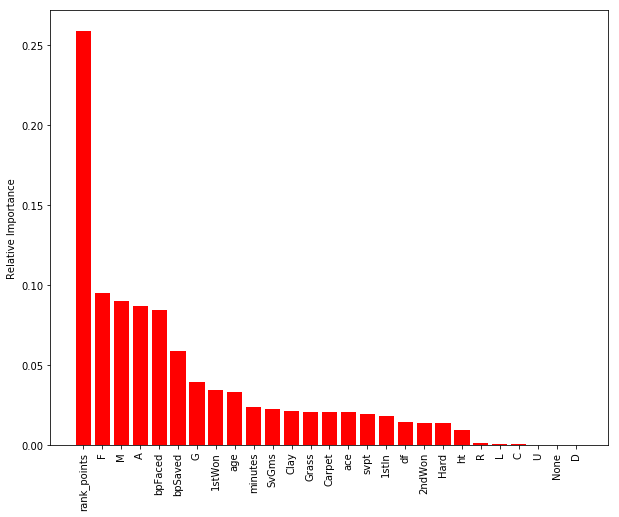

In [85]:
sort_importance = importance.sort_values(by='Importance',ascending=False)
x = sort_importance.index
y = sort_importance.iloc[:, 0]

plt.figure(figsize=(10,8))
plt.bar(x, y, align="center",color='red',linewidth=2)
plt.xticks(rotation=90)
plt.ylabel('Relative Importance',)
plt.show()

# Not working

In [67]:
## Code testing with David Ferrer

player = 'David Ferrer'


one_year=timedelta(days=370)

#for training...
gen_row = []
one_row = []

#iterates over columns, without 'iterrows()'!
for idx, row in df_test[(df_test.tourney_date.apply(lambda x:x.year)<2011) \
                        & (df_test.tourney_date.apply(lambda x:x.year)>2008)].iterrows():
    date = row['tourney_date']
    df_one_year_in_2008_10 = df_test[(df_test.tourney_date<date) & (df_test.tourney_date> date-one_year)]
    df_one_year_in_2008_10.drop(['tourney_date'], axis=1,inplace=True)
    
    #worked momentarily but not working anymore, ...
    #...but funny to have a random index, but not working if 'igonre_index=True' in .append() method
    #gen_row[np.random.random()] = dict(df_one_year_in_2008_10[df_one_year_in_2008_10['name']==player].drop('name',axis=1).aggregate(np.mean))
    #df_preds_2009_11.append(gen_row)
    
    # still does not like not having index, and 'igonre_index=Ture' in .append() method yield an empty output 
    # gen_row = dict(df_one_year_in_2008_10[df_one_year_in_2008_10['name']==player].drop('name',axis=1).aggregate(np.mean))
    
    
    one_row = df_one_year_in_2008_10[df_one_year_in_2008_10['name']==player].drop('name',axis=1).aggregate(np.mean)
    gen_row.append(one_row)

    
    
    #print(gen_row)
    #if idx > 0:
    #    break
    
     
df_preds_2009_11= pd.DataFrame()   
# df_preds_2009_11.index
# df_preds_2009_11
gen_row


## For efficiency implement this, tuples timed to be better than list/dict in SO:
## https://stackoverflow.com/questions/12376863/adding-calculated-columns-to-a-dataframe-in-pandas?rq=1

# d = []
# for p in game.players.passing():
#     d.append((p, p.team, p.passer_rating()))

# pd.DataFrame(d, columns=('Player', 'Team', 'Passer Rating'))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


[minutes         113.311475
 ht              175.000000
 age              26.139159
 rank_points    2725.245902
 ace               2.688525
 df                1.655738
 svpt             78.590164
 1stIn            51.688525
 1stWon           35.131148
 2ndWon           14.360656
 SvGms            12.344262
 bpSaved           3.950820
 bpFaced           6.639344
 Carpet            0.000000
 Clay              0.442623
 Grass             0.131148
 Hard              0.426230
 None              0.000000
 L                 0.000000
 R                 1.000000
 U                 0.000000
 A                 0.508197
 C                 0.000000
 D                 0.000000
 F                 0.000000
 G                 0.262295
 M                 0.229508
 target            0.655738
 dtype: float64, minutes         115.573770
 ht              175.000000
 age              26.221788
 rank_points    2788.770492
 ace               2.606557
 df                1.836066
 svpt             80.163934
 1st

# _ASIDE_: Cool python/pandas stuff